# E Commerce Recommendation System


# This Script Provides Product Recommendations Hybrid Recommendation Function.

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle


# Loading data

In [2]:

df = pd.read_csv("data.csv", encoding='ISO-8859-1')
df.shape

(541909, 8)

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.isnull().sum()   

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# Data Cleaning


In [27]:
df.dropna(subset=['CustomerID', 'Description'], inplace=True)

In [28]:
print((df['Quantity'] <= 0).sum())

0


In [29]:
df = df[df['Quantity'] > 0]

In [30]:
df.shape

(50000, 9)

In [31]:
df.nunique()  

InvoiceNo      2520
StockCode      2641
Description    2656
Quantity        137
InvoiceDate    2368
UnitPrice       164
CustomerID     1366
Country          25
TotalPrice     1072
dtype: int64

In [32]:
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

In [33]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [34]:
df = df.head(50000)  
df.shape

(50000, 9)

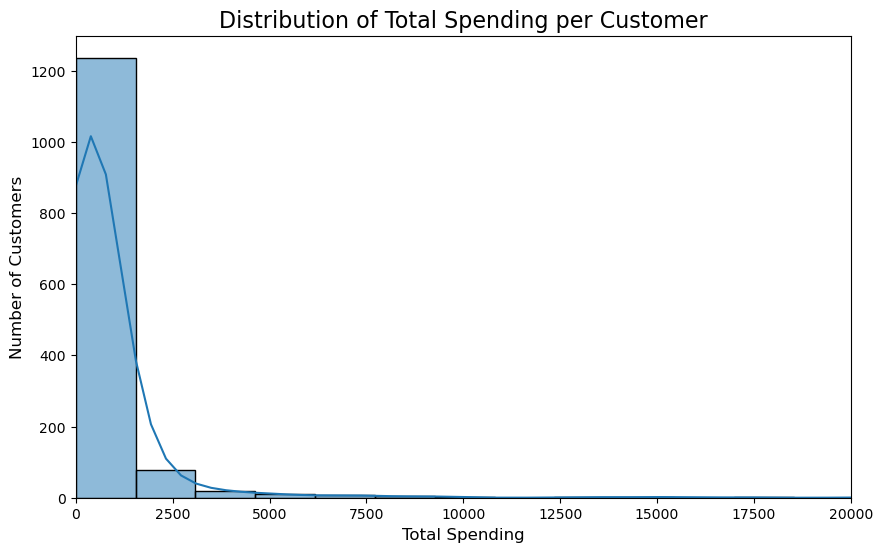


Summary of customer spending:
count     1366.000000
mean       878.842394
std       2900.185042
min          0.850000
25%        209.135000
50%        367.790000
75%        743.590000
max      77183.600000
Name: TotalPrice, dtype: float64


In [35]:
customer_spending = df.groupby('CustomerID')['TotalPrice'].sum()

plt.figure(figsize=(10, 6))
sns.histplot(customer_spending, bins=50, kde=True)
plt.title('Distribution of Total Spending per Customer', fontsize=16)
plt.xlabel('Total Spending', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xlim(0, 20000)
plt.show()
print("\nSummary of customer spending:")
print(customer_spending.describe())

In [36]:
df.TotalPrice.nlargest(10)

61619    77183.60
52711     6539.40
52709     4921.50
52772     4522.50
52134     4121.64
16438     3828.00
19871     3794.40
52710     3700.00
52771     3315.00
52132     3272.40
Name: TotalPrice, dtype: float64

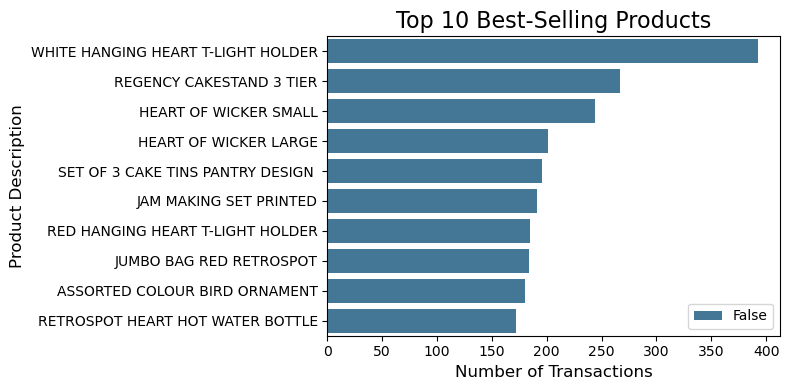

In [37]:
plt.figure(figsize=(8, 4))
product_counts = df['Description'].value_counts().head(10)

sns.barplot(y=product_counts.index, x=product_counts.values, palette="mako",hue=False)
plt.title('Top 10 Best-Selling Products', fontsize=16)
plt.xlabel('Number of Transactions', fontsize=12)
plt.ylabel('Product Description', fontsize=12)
plt.tight_layout()
plt.show()

# Getting Unique products


In [38]:

products = df[['StockCode', 'Description']].drop_duplicates().reset_index(drop=True)


In [39]:
products.head()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


In [40]:
products.shape

(2668, 2)

# Collaborative Filtering (Co-purchase)

### We are creating a basket matrix: rows are invoices, columns are products, values = 1 if bought.

In [41]:
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
basket = (basket > 0).astype(int)

# Computeing co-purchase similarity (item-based)
co_purchase_sim = cosine_similarity(basket.T)
co_purchase_df = pd.DataFrame(co_purchase_sim, index=basket.columns, columns=basket.columns)


In [42]:
co_purchase_df.head()

Description,4 PURPLE FLOCK DINNER CANDLES,OVAL WALL MIRROR DIAMANTE,SET 2 TEA TOWELS I LOVE LONDON,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,YULETIDE IMAGES S/6 PAPER BOXES,ZINC FINISH 15CM PLANTER POTS,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
Description,,,,,,,,,,,,,,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.060634,0.0,0.000000
OVAL WALL MIRROR DIAMANTE,0.0,1.000000,0.036037,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.048912,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.073127,0.0,0.000000
SET 2 TEA TOWELS I LOVE LONDON,0.0,0.036037,1.000000,0.019139,0.036037,0.059761,0.037796,0.0,0.023002,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.042258,0.0,0.028989,0.0,0.000000
10 COLOUR SPACEBOY PEN,0.0,0.000000,0.019139,1.000000,0.048280,0.000000,0.000000,0.0,0.000000,0.051952,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.038837,0.0,0.033389
12 COLOURED PARTY BALLOONS,0.0,0.000000,0.036037,0.048280,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000


In [43]:
basket.head()

Description,4 PURPLE FLOCK DINNER CANDLES,OVAL WALL MIRROR DIAMANTE,SET 2 TEA TOWELS I LOVE LONDON,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,YULETIDE IMAGES S/6 PAPER BOXES,ZINC FINISH 15CM PLANTER POTS,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Content-Based Filtering (TF-IDF)

In [44]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(products['Description'])

content_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
content_df = pd.DataFrame(content_sim, index=products['Description'], columns=products['Description'])


In [45]:
content_sim

array([[1.        , 0.19933093, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19933093, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.07114289,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.07114289, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [46]:
content_df.head()   

Description,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER,KNITTED UNION FLAG HOT WATER BOTTLE,RED WOOLLY HOTTIE WHITE HEART.,SET 7 BABUSHKA NESTING BOXES,GLASS STAR FROSTED T-LIGHT HOLDER,HAND WARMER UNION JACK,HAND WARMER RED POLKA DOT,ASSORTED COLOUR BIRD ORNAMENT,...,GLITTER HEART DECORATION,PINK JEWELLED PHOTO FRAME,PINK JEWELLED PHOTO FRAME,GINGHAM HEART DECORATION,PINK GAUZE BUTTERFLY LAMPSHADE,CHERRY BLOSSOM CANVAS ART PICTURE,BOTANICAL LAVENDER GIFT WRAP,PINK/PURPLE RETRO RADIO,MEDIUM PINK BUDDHA HEAD,"PET MUG, GOLDFISH"
Description,,,,,,,,,,,,,,,,,,,,,
WHITE HANGING HEART T-LIGHT HOLDER,1.000000,0.199331,0.0,0.0,0.247817,0.0,0.352863,0.000000,0.000000,0.0,...,0.173677,0.0,0.0,0.183338,0.0,0.0,0.0,0.0,0.0,0.0
WHITE METAL LANTERN,0.199331,1.000000,0.0,0.0,0.145785,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
CREAM CUPID HEARTS COAT HANGER,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
KNITTED UNION FLAG HOT WATER BOTTLE,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.183876,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
RED WOOLLY HOTTIE WHITE HEART.,0.247817,0.145785,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.076402,0.0,...,0.127022,0.0,0.0,0.134088,0.0,0.0,0.0,0.0,0.0,0.0


# Hybrid Recommendation Function

  ###  This Is A Hybrid recommendation using: alpha = weight for content-based similarity
  ###  (1-alpha) = weight for collaborative similarity

In [47]:
def hybrid_recommendation(product_name, top_n=5, alpha=0.5):
  
    if product_name not in content_df.index or product_name not in co_purchase_df.columns:
        return []
    content_scores = content_df[product_name]
    
    collab_scores = co_purchase_df[product_name]
    
    hybrid_scores = alpha*content_scores + (1-alpha)*collab_scores
    hybrid_scores = hybrid_scores.drop(product_name)
    
    top_products = hybrid_scores.sort_values(ascending=False).head(top_n)
    return list(top_products.index)


In [51]:
# Testing Models
test_product = random.choice(products['Description'].tolist())
print(f"Test Product: {test_product}\n")
recommendations = hybrid_recommendation(test_product, top_n=5, alpha=0.5)
print(recommendations)

Test Product: CROCHET ROSE PURSE WITH SUEDE BACK

['LA PALMIERA TILE HOOK', 'PSYCHEDELIC TILE HOOK', 'DOG TOY WITH PINK CROCHET SKIRT', 'COSMETIC BAG VINTAGE ROSE PAISLEY', 'FLOWERS TILE HOOK']


# Saving Models

In [52]:
import os

os.makedirs('models', exist_ok=True)

with open('models/co_purchase.pkl', 'wb') as f:
    pickle.dump(co_purchase_df, f)

with open('models/content.pkl', 'wb') as f:
    pickle.dump(content_df, f)

with open('models/products.pkl', 'wb') as f:
    pickle.dump(products, f)

with open('models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)


In [ ]:
# BY -Gaikwad Om